# Imports

In [1]:
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, WeightedRandomSampler, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import ReduceLROnPlateau
from collections import Counter

import numpy as np, matplotlib.pyplot as plt, seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Dataset

In [3]:
path = "./facialdata"

# Data Preprocessing

In [4]:
transform = transforms.Compose([
    transforms.Resize((48, 48)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [5]:
# Data loaders
# Split the dataset into train and test sets
full_dataset = ImageFolder(path, transform=transform)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [6]:
labels = [label for _, label in full_dataset.samples]
class_counts = Counter(labels)

print(class_counts)

Counter({0: 3205, 2: 3205, 3: 3205, 4: 3205, 5: 3205, 6: 3205, 1: 547})


In [7]:
weights = [0] * len(class_counts)

for cls_idx, count in class_counts.items():
    weights[cls_idx] = 1.0 / count

class_weights = torch.FloatTensor(weights).to(device)

print(class_weights)

tensor([0.0003, 0.0018, 0.0003, 0.0003, 0.0003, 0.0003, 0.0003],
       device='cuda:0')


# Model Layer Setup

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # input_shape=(1,48,48)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        
        self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)  # padding=2 for 'same' with kernel=5
        self.bn2 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)
        
        self.conv4 = nn.Conv2d(128, 512, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(512)
        self.pool3 = nn.MaxPool2d(2, 2)
        self.dropout3 = nn.Dropout(0.25)
        
        self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(2, 2)
        self.dropout4 = nn.Dropout(0.25)
        
        self.flatten_dim = 512 * 3 * 3  # After 4 maxpools on 48x48 input: 48->24->12->6->3
        
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.bn5 = nn.BatchNorm1d(256)
        self.dropout5 = nn.Dropout(0.25)
        
        self.fc2 = nn.Linear(256, 512)
        self.bn6 = nn.BatchNorm1d(512)
        self.dropout6 = nn.Dropout(0.25)
        
        self.fc3 = nn.Linear(512, 7)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.bn1(x)
        x = self.pool1(x)
        x = self.dropout1(x)
        
        x = F.relu(self.conv3(x))
        x = self.bn2(x)
        x = self.pool2(x)
        x = self.dropout2(x)
        
        x = F.relu(self.conv4(x))
        x = self.bn3(x)
        x = self.pool3(x)
        x = self.dropout3(x)
        
        x = F.relu(self.conv5(x))
        x = self.bn4(x)
        x = self.pool4(x)
        x = self.dropout4(x)
        
        x = x.view(-1, self.flatten_dim)
        
        x = F.relu(self.fc1(x))
        x = self.bn5(x)
        x = self.dropout5(x)
        
        x = F.relu(self.fc2(x))
        x = self.bn6(x)
        x = self.dropout6(x)
        
        x = self.fc3(x)
        return F.log_softmax(x, dim=1) 

# Optimizer Setup

In [9]:
model = CNN().to(device)


# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6)

# Count parameters
total_params = 0
trainable_params = 0

for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params += param.numel()
    total_params += param.numel()

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 4492935
Trainable parameters: 4492935


# Training Loop

In [10]:
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_acc = correct / total
    train_loss = total_loss

    model.eval()
    val_loss, val_correct, val_total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_acc = val_correct / val_total
    avg_val_loss = val_loss / len(test_loader)

    scheduler.step(avg_val_loss) 

    print(f"Epoch {epoch+1:>2}/{num_epochs} | Train Loss: {train_loss:.4f} | LR: {scheduler.optimizer.param_groups[0]['lr']:.6f} | Train Acc: {train_acc:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch  1/50 | Train Loss: 495.8967 | LR: 0.001000 | Train Acc: 0.1932 | Val Loss: 1.8909 | Val Acc: 0.2417
Epoch  2/50 | Train Loss: 463.6025 | LR: 0.001000 | Train Acc: 0.2474 | Val Loss: 1.7488 | Val Acc: 0.2978
Epoch  3/50 | Train Loss: 434.0860 | LR: 0.001000 | Train Acc: 0.3010 | Val Loss: 1.7124 | Val Acc: 0.3023
Epoch  4/50 | Train Loss: 419.8096 | LR: 0.001000 | Train Acc: 0.3255 | Val Loss: 1.7125 | Val Acc: 0.3443
Epoch  5/50 | Train Loss: 395.1324 | LR: 0.001000 | Train Acc: 0.3707 | Val Loss: 1.5269 | Val Acc: 0.3966
Epoch  6/50 | Train Loss: 380.5797 | LR: 0.001000 | Train Acc: 0.3895 | Val Loss: 2.0777 | Val Acc: 0.3059
Epoch  7/50 | Train Loss: 364.8858 | LR: 0.001000 | Train Acc: 0.4172 | Val Loss: 1.4287 | Val Acc: 0.4398
Epoch  8/50 | Train Loss: 348.0037 | LR: 0.001000 | Train Acc: 0.4405 | Val Loss: 1.4189 | Val Acc: 0.4378
Epoch  9/50 | Train Loss: 338.9378 | LR: 0.001000 | Train Acc: 0.4632 | Val Loss: 1.4562 | Val Acc: 0.4302
Epoch 10/50 | Train Loss: 335.4433 | 

In [11]:
torch.save(model.state_dict(), "./model.pth")
print("✅ Training complete. Model saved.")

✅ Training complete. Model saved.


# Test Confusion Matrix

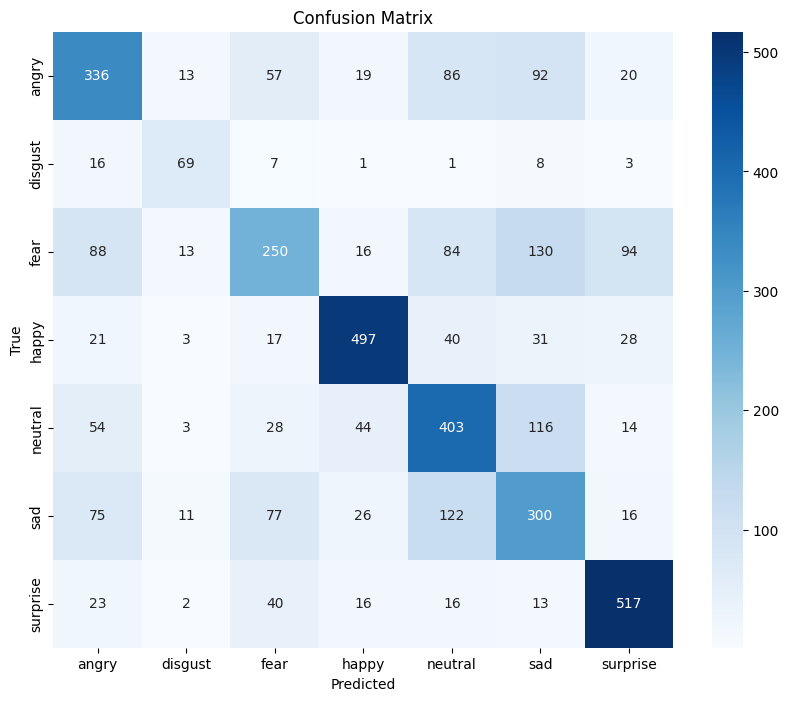

In [12]:
def plot_confusion_matrix(model, test_loader, class_names):
    all_preds = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, test_loader,class_names=full_dataset.classes)
